In [1]:
import nilearn
from nibabel.testing import data_path
from nilearn import datasets, plotting, regions
import brainspace
import pandas as pd
import numpy as np
import os
from nilearn import surface
import nibabel as nib
import matplotlib.pyplot as plt
from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "all"
#import hcp_utils as hcp
from sklearn.neighbors import NearestNeighbors
import seaborn as sns

In [2]:
subjects = np.loadtxt("HCP/subj.txt", dtype = "str")

In [3]:
grads_ses1_4k_aligned = np.load("grads_ses1_4k_aligned.npy")
grads_ses2_4k_aligned = np.load("grads_ses2_4k_aligned.npy")

In [81]:

vd_subject_list_ses1 = []
for subject_grads in grads_ses1_4k_aligned:
    vertex_coords = subject_grads.T
    vertex_nbrs = NearestNeighbors(n_neighbors=500, algorithm='brute').fit(vertex_coords)
    distances, indices = vertex_nbrs.neighbors(vertex_coords)
    mean_distances = distances.mean(axis = 1)
    vd_subject_list_ses1.append(mean_distances)


vd_subject_list_ses2 = []
for subject_grads in grads_ses2_4k_aligned:
    vertex_coords = subject_grads.T
    vertex_nbrs = NearestNeighbors(n_neighbors=500, algorithm='brute').fit(vertex_coords)
    distances, indices = vertex_nbrs.kneighbors(vertex_coords)
    mean_distances = distances.mean(axis = 1)
    vd_subject_list_ses2.append(mean_distances)

In [4]:
neighbours = [50, 100, 200, 400, 800, 1600]
ICC_df_diff_neighbours = []
for n_neighbours in neighbours:
    vd_subject_list_ses1 = []
    for subject_grads in grads_ses1_4k_aligned:
        vertex_coords = subject_grads.T
        vertex_nbrs = NearestNeighbors(n_neighbors=500, algorithm='brute').fit(vertex_coords)
        distances, indices = vertex_nbrs.kneighbors(vertex_coords)
        mean_distances = distances.mean(axis = 1)
        vd_subject_list_ses1.append(mean_distances)


    vd_subject_list_ses2 = []
    for subject_grads in grads_ses2_4k_aligned:
        vertex_coords = subject_grads.T
        vertex_nbrs = NearestNeighbors(n_neighbors=500, algorithm='brute').fit(vertex_coords)
        distances, indices = vertex_nbrs.kneighbors(vertex_coords)
        mean_distances = distances.mean(axis = 1)
        vd_subject_list_ses2.append(mean_distances)
    vd_ses1 = np.asarray(vd_subject_list_ses1)
    vd_ses2 = np.asarray(vd_subject_list_ses2)


    vd_ses1_df = pd.DataFrame(vd_ses1[0], columns = ["Dispersion"])
    vd_ses1_df["Subject"] = subjects[0]
    vd_ses1_df["Session"] = 1
    vd_ses1_df["Vertex"] = np.arange(len(vd_ses1[0]))

    for subject, vd_array in zip(subjects[1:], vd_ses1):
        df = pd.DataFrame(vd_array, columns = ["Dispersion"])
        df["Subject"] = subject
        df["Session"] = 1
        df["Vertex"] = np.arange(len(vd_array))
        vd_ses1_df = pd.concat([vd_ses1_df, df])
    
    vd_ses2_df = pd.DataFrame(vd_ses2[0], columns = ["Dispersion"])
    vd_ses2_df["Subject"] = subjects[0]
    vd_ses2_df["Session"] = 2
    vd_ses2_df["Vertex"] = np.arange(len(vd_ses2[0]))

    for subject, vd_array in zip(subjects[1:], vd_ses2):
        df = pd.DataFrame(vd_array, columns = ["Dispersion"])
        df["Subject"] = subject
        df["Session"] = 2
        df["Vertex"] = np.arange(len(vd_array))
        vd_ses2_df = pd.concat([vd_ses2_df, df])
    
    vd_df = pd.concat([vd_ses1_df, vd_ses2_df])
    vd_df["Neighbours"] = n_neighbours
    ICC_df_diff_neighbours.append(vd_df)
ICC_df_diff_neighbours = pd.concat(ICC_df_diff_neighbours)
    
    

In [12]:
%%capture
from pingouin import intraclass_corr

vertices = np.arange(len(vd_ses1[0]))
vertex_wise_ICC_diff_neighbours = []
for n_neighbours in neighbours:
    vertex_wise_ICC = []
    for vertex in vertices:
        data = ICC_df_diff_neighbours[(ICC_df_diff_neighbours["Vertex"] == vertex) & (ICC_df_diff_neighbours["Neighbours"] == n_neighbours)]
        ICC = intraclass_corr(data, targets = "Subject", raters = "Session", ratings = "Dispersion")
        ICC["Vertex"] = vertex
        ICC["Neighbours"] = n_neighbours
        vertex_wise_ICC.append(ICC[ICC["Type"] == "ICC2"])
    vertex_wise_ICC = pd.concat(vertex_wise_ICC)
    vertex_wise_ICC_diff_neighbours.append(vertex_wise_ICC)
vertex_wise_ICC_diff_neighbours = pd.concat(vertex_wise_ICC_diff_neighbours)


<AxesSubplot: xlabel='Neighbours', ylabel='ICC'>

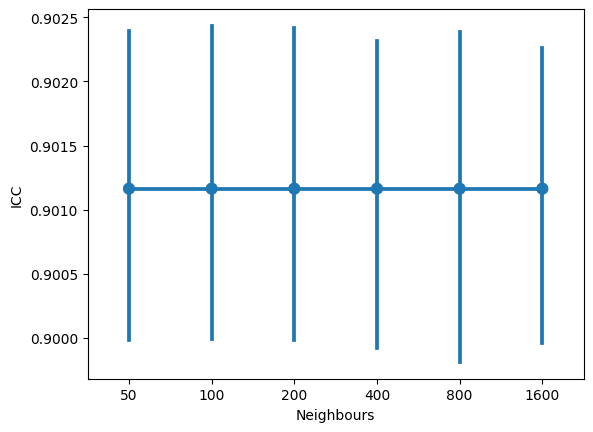

In [14]:
sns.pointplot(vertex_wise_ICC_diff_neighbours, x = "Neighbours", y ="ICC")

In [153]:
ICC_df_diff_neighbours

Dispersion Subject  Session  Vertex  Neighbours
0       0.616283  100206        1       0          50
1       0.516630  100206        1       1          50
2       0.617859  100206        1       2          50
3       0.787981  100206        1       3          50
4       1.251462  100206        1       4          50
...          ...     ...      ...     ...         ...
7339    0.807647  101006        2    7339        1600
7340    1.307247  101006        2    7340        1600
7341    0.803449  101006        2    7341        1600
7342    0.748071  101006        2    7342        1600
7343    0.845878  101006        2    7343        1600

[440640 rows x 5 columns]

In [82]:
vd_ses1 = np.asarray(vd_subject_list_ses1)
vd_ses2 = np.asarray(vd_subject_list_ses2)

In [20]:
labs_L_4k_metric = nib.load('HCP/labels/fsLR.4k.L.label_metric.gii').agg_data() # loading labels resampled with 2 diff. techniques
labs_R_4k_metric = nib.load('HCP/labels/fsLR.4k.R.label_metric.gii').agg_data()
labs_4k_metric  = np.concatenate((labs_L_4k_metric, labs_R_4k_metric))

labs_L_4k = nib.load('HCP/labels/fsLR.4k.L.label.gii').agg_data()
labs_R_4k = nib.load('HCP/labels/fsLR.4k.R.label.gii').agg_data()
labs_4k  = np.concatenate((labs_L_4k, labs_R_4k)) # the right labels

In [78]:
labs_4k_metric = labs_4k_metric.astype(float)
labs_4k_metric[labs_4k_metric == 0] = np.nan
cortical_indices_4k_metric = np.where(np.isnan(labs_4k_metric) == False)[0]

labs_4k = labs_4k.astype(float)
labs_4k[labs_4k == 0] = np.nan
medial_wall_mask = np.where(np.isnan(labs_4k) == True)[0] # medial wall mask from the right labels

In [83]:
vd_surf_ses1 = np.empty((5, 8004))
vd_surf_ses1[:] = np.nan
for subject, subject_map in zip(vd_ses1, vd_surf_ses1):
    subject_map[cortical_indices_4k_metric] = subject
    subject_map[medial_wall_mask] = np.nan


vd_surf_ses2 = np.empty((5, 8004))
vd_surf_ses2[:] = np.nan
for subject, subject_map in zip(vd_ses2, vd_surf_ses2):
    subject_map[cortical_indices_4k_metric] = subject
    subject_map[medial_wall_mask] = np.nan

In [16]:
vd_surf_ses1.shape

(5, 8004)

Text(0.5, 1.0, 'VD: S1, Ses 1, 500 neighbors')

Text(0.5, 1.0, 'VD: S1, Ses 2, 500 neighbors')

Text(0.5, 1.0, 'VD: S2, Ses 1, 500 neighbors')

Text(0.5, 1.0, 'VD: S2, Ses 2, 500 neighbors')

/var/folders/2m/72fcyjmd7vs3g18rkfwx7nw40000gn/T/ipykernel_90853/3104352340.py:27: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  vd_s1_ses1_plot.show()
/var/folders/2m/72fcyjmd7vs3g18rkfwx7nw40000gn/T/ipykernel_90853/3104352340.py:28: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  vd_s1_ses2_plot.show()
/var/folders/2m/72fcyjmd7vs3g18rkfwx7nw40000gn/T/ipykernel_90853/3104352340.py:29: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  vd_s2_ses1_plot.show()
/var/folders/2m/72fcyjmd7vs3g18rkfwx7nw40000gn/T/ipykernel_90853/3104352340.py:30: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  vd_s2_ses2_plot.show()


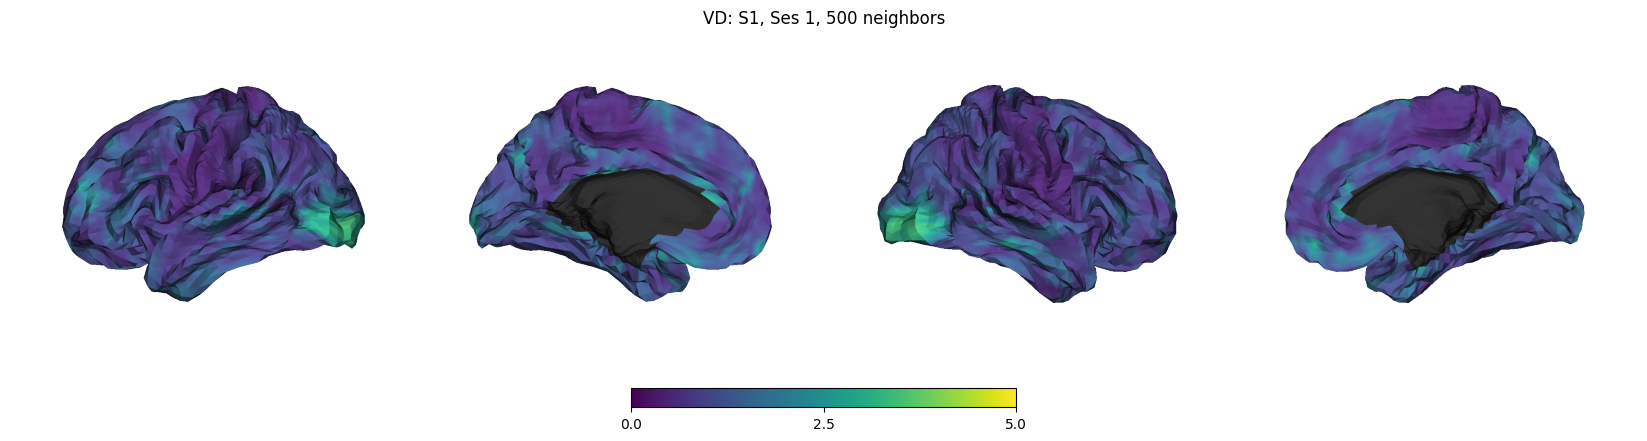

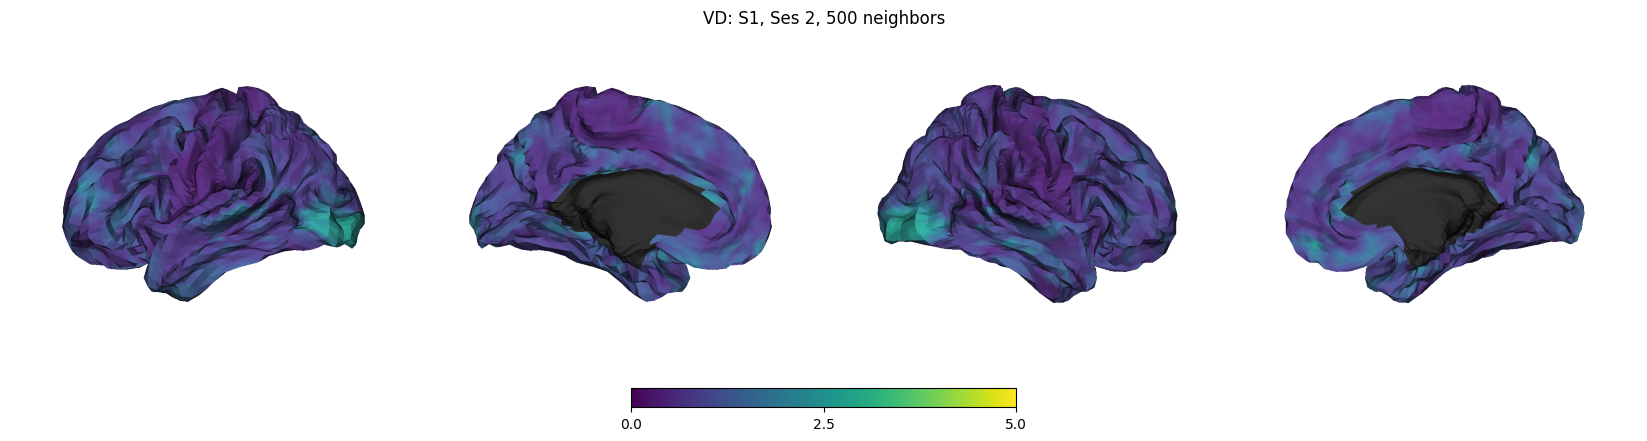

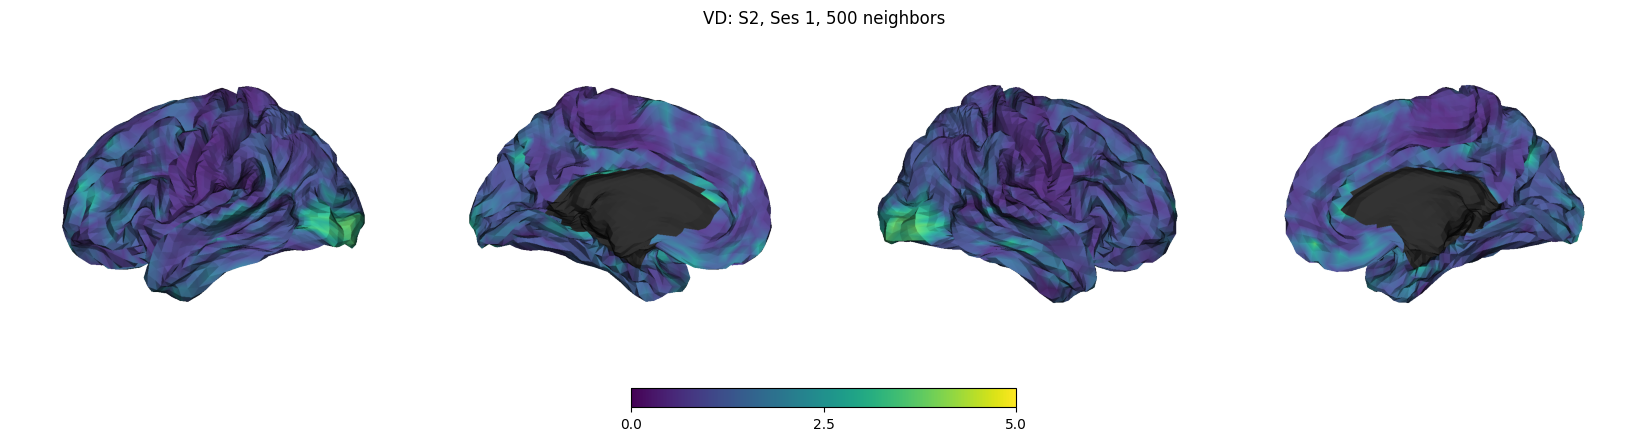

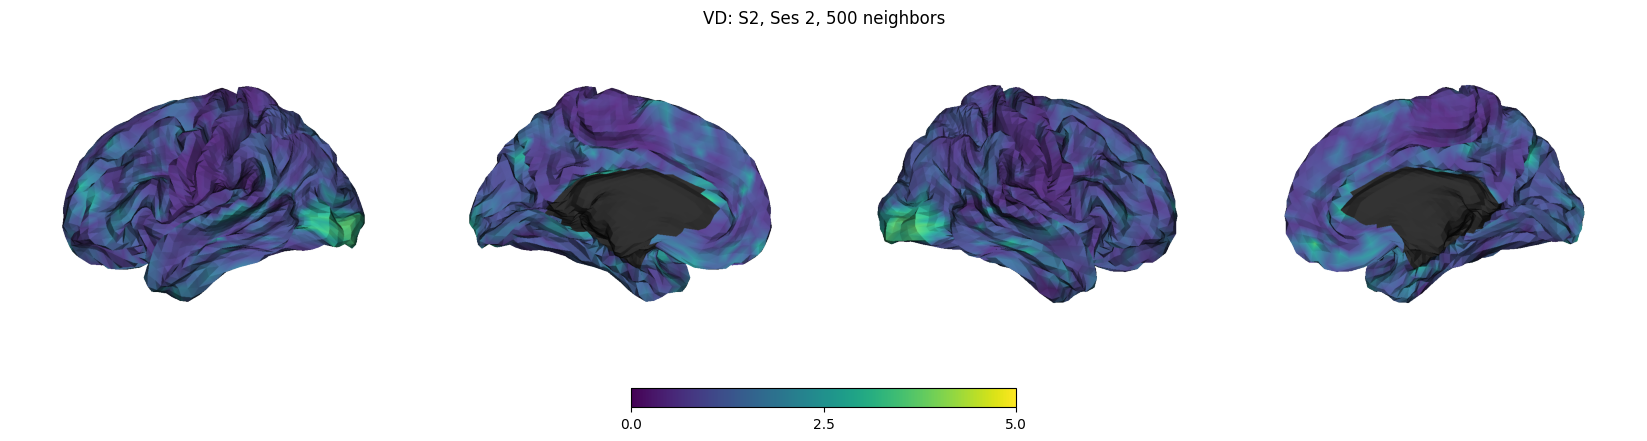

In [85]:
from surfplot.plotting import Plot # plotting gradient dispersion

vd_s1_ses1_plot = Plot("HCP/surfaces/fslr_L_mid_4k.gii", "HCP/surfaces/fslr_R_mid_4k.gii", layout='row', zoom=1.2, size=(2000,400), mirror_views=False) 
vd_s1_ses2_plot = Plot("HCP/surfaces/fslr_L_mid_4k.gii", "HCP/surfaces/fslr_R_mid_4k.gii", layout='row', zoom=1.2, size=(2000,400), mirror_views=False)
vd_s2_ses1_plot = Plot("HCP/surfaces/fslr_L_mid_4k.gii", "HCP/surfaces/fslr_R_mid_4k.gii", layout='row', zoom=1.2, size=(2000,400), mirror_views=False)
vd_s2_ses2_plot = Plot("HCP/surfaces/fslr_L_mid_4k.gii", "HCP/surfaces/fslr_R_mid_4k.gii", layout='row', zoom=1.2, size=(2000,400), mirror_views=False)

vd_s1_ses1_plot.add_layer(vd_surf_ses1[0], cmap='viridis', color_range = (0, 5))
vd_s1_ses2_plot.add_layer(vd_surf_ses2[0], cmap='viridis', color_range = (0, 5))

vd_s2_ses1_plot.add_layer(vd_surf_ses1[1], cmap='viridis', color_range = (0, 5))
vd_s2_ses2_plot.add_layer(vd_surf_ses2[1], cmap='viridis', color_range = (0, 5))


vd_s1_ses1_plot = vd_s1_ses1_plot.build()
vd_s1_ses1_plot.axes[0].set_title("VD: S1, Ses 1, 500 neighbors")

vd_s1_ses2_plot = vd_s1_ses2_plot.build()
vd_s1_ses2_plot.axes[0].set_title("VD: S1, Ses 2, 500 neighbors")

vd_s2_ses1_plot = vd_s2_ses1_plot.build()
vd_s2_ses1_plot.axes[0].set_title("VD: S2, Ses 1, 500 neighbors")

vd_s2_ses2_plot = vd_s2_ses2_plot.build()
vd_s2_ses2_plot.axes[0].set_title("VD: S2, Ses 2, 500 neighbors")

vd_s1_ses1_plot.show()
vd_s1_ses2_plot.show()
vd_s2_ses1_plot.show()
vd_s2_ses2_plot.show()

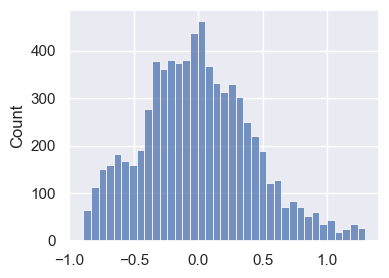

In [104]:
sns.set(rc={'figure.figsize':(4,3)})
fig = sns.histplot(np.log(vd_surf_ses2[4]))


Intra-class Correlation 

In [ ]:
vd_ses1_long = vd_ses1.reshape(5 * len(vd_ses1[0]))
vd_ses2_long = vd_ses2.reshape(5 * len(vd_ses2[0]))

In [102]:
vertices = np.arange(len(vd_ses1[0]))

In [109]:
# Long format of the 1st session

vd_ses1_df = pd.DataFrame(vd_ses1[0], columns = ["Dispersion"])
vd_ses1_df["Subject"] = subjects[0]
vd_ses1_df["Session"] = 1
vd_ses1_df["Vertex"] = np.arange(len(vd_ses1[0]))

for subject, vd_array in zip(subjects[1:], vd_ses1):
    df = pd.DataFrame(vd_array, columns = ["Dispersion"])
    df["Subject"] = subject
    df["Session"] = 1
    df["Vertex"] = np.arange(len(vd_array))
    vd_ses1_df = pd.concat([vd_ses1_df, df])

In [110]:
# Long format of the 2nd session

vd_ses2_df = pd.DataFrame(vd_ses2[0], columns = ["Dispersion"])
vd_ses2_df["Subject"] = subjects[0]
vd_ses2_df["Session"] = 2
vd_ses2_df["Vertex"] = np.arange(len(vd_ses2[0]))

for subject, vd_array in zip(subjects[1:], vd_ses2):
    df = pd.DataFrame(vd_array, columns = ["Dispersion"])
    df["Subject"] = subject
    df["Session"] = 2
    df["Vertex"] = np.arange(len(vd_array))
    vd_ses2_df = pd.concat([vd_ses2_df, df])

In [113]:
vd_df = pd.concat([vd_ses1_df, vd_ses2_df])

In [151]:
vd_df["Subject"].unique()

array(['100206', '100307', '100408', '100610', '101006'], dtype=object)

In [112]:
%%capture
from pingouin import intraclass_corr

vertex_wise_ICC = []
for vertex in vertices:
        data = vd_df[vd_df["Vertex"] == vertex]
        ICC = intraclass_corr(data, targets = "Subject", raters = "Session", ratings = "Dispersion")
        ICC["Vertex"] = vertex
        vertex_wise_ICC.append(ICC[ICC["Type"] == "ICC2"])

In [115]:
vertex_wise_ICC = pd.concat(vertex_wise_ICC)

In [135]:
ICC_vis = vertex_wise_ICC[["ICC"]]
ICC_vis.min()

ICC    0.748079
dtype: float64

In [129]:
ICC_vis.loc[ICC_vis["ICC"] < 0.4, "ICC"] = np.nan

/var/folders/2m/72fcyjmd7vs3g18rkfwx7nw40000gn/T/ipykernel_90853/4153902346.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  ICC_vis.loc[ICC_vis["ICC"] < 0.4, "ICC"] = np.nan


In [130]:
ICC_plot_df = np.empty(len(labs_4k))
ICC_plot_df[cortical_indices_4k_metric] = ICC_vis["ICC"]
ICC_plot_df[medial_wall_mask] = np.nan

In [142]:
ICC_plot_df

array([0.96329877, 0.94239334, 0.90640886, ..., 0.92854394, 0.95887162,
       0.93224967])

In [143]:
np.nanmin(ICC_plot_df)

0.7480791494605054

In [131]:
np.asarray(np.where(np.isnan(ICC_plot_df) == True)).shape

(1, 685)

Text(0.5, 1.0, 'Vertex-wise ICC')

/var/folders/2m/72fcyjmd7vs3g18rkfwx7nw40000gn/T/ipykernel_90853/771868433.py:7: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  ICCplot.show()


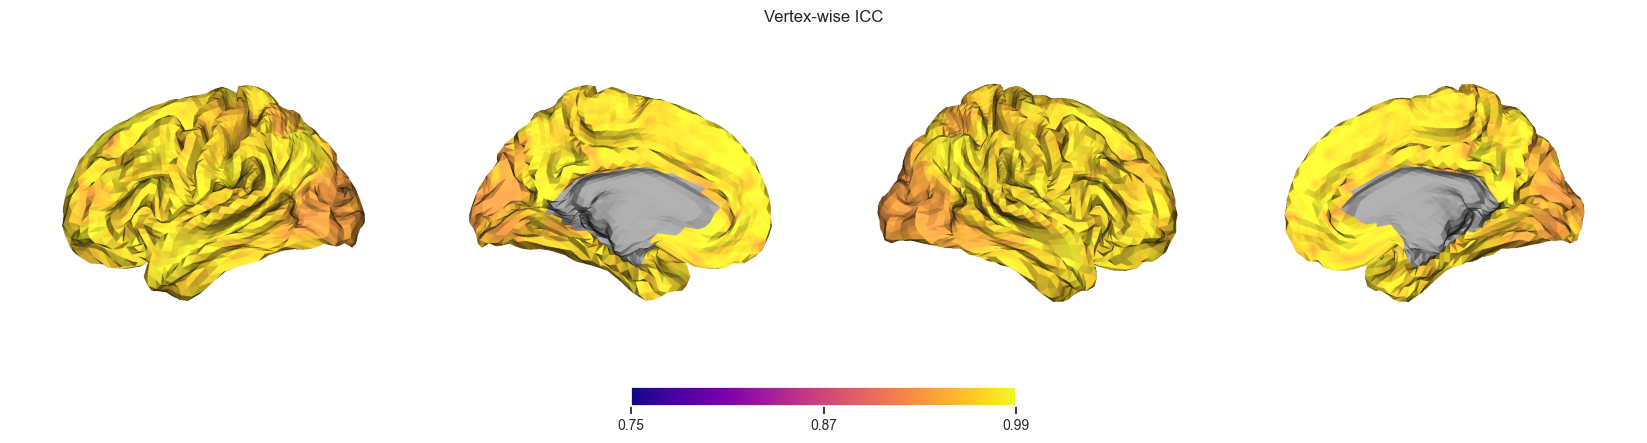

In [144]:
ICCplot = Plot("HCP/surfaces/fslr_L_mid_4k.gii", "HCP/surfaces/fslr_R_mid_4k.gii", layout='row', zoom=1.2, size=(2000,400), mirror_views=False) 

ICCplot.add_layer(ICC_plot_df, cmap='plasma')
ICCplot = ICCplot.build()
ICCplot.axes[0].set_title("Vertex-wise ICC")

ICCplot.show()

## Resampling surfaces to 4k

In [7]:
from austin_utils import save_gifti

In [102]:
sessions = [labeled_grads_ses1, labeled_grads_ses2]
hemi_L = "L"
hemi_R = "R"
grads = ["1", "2", "3"]
filenames_L= []
filenames_R = []
gii_paths_L= []
gii_paths_R = []
for session, session_n in zip(sessions, ["1", "2"]):
    for subject, id in zip(session, subjects):
        for gradient_array, grad in zip(subject, grads):
            filename_L = "%s_grad%s_ses%s_%s" % (id, grad, session_n, hemi_L)
            filename_R = "%s_grad%s_ses%s_%s" % (id, grad, session_n, hemi_R)
            save_gifti(gradient_array[:int(len(gradient_array)/2)], filename_L)
            save_gifti(gradient_array[int(len(gradient_array)/2):], filename_R)
            filenames_L.append(filename_L)
            filenames_R.append(filename_R)
            gii_paths_L.append("/Users/VictoriaShevchenko/Documents/PhD/"+ filename_L + ".func.gii")
            gii_paths_R.append("/Users/VictoriaShevchenko/Documents/PhD/"+ filename_R + ".func.gii")


            

In [196]:
np.asarray(np.where(np.isnan(labeled_grads_ses1[0]) == True))

array([], shape=(2, 0), dtype=int64)

In [195]:
labeled_grads_ses1[0].shape

(3, 64984)

In [103]:
%%capture
# Resampling surface gradient maps to 4k
directory = "/Users/VictoriaShevchenko/Documents/PhD/HCP/resampled_grads/"
import os
for path_L, filename_L in zip(gii_paths_L, filenames_L):
    out_file = directory + filename_L + "4k.func.gii"
    os.system("wb_command -metric-resample %s /Users/VictoriaShevchenko/Documents/PhD/HCP/spheres/S1200.L.sphere.32k_fs_LR.surf.gii /Users/VictoriaShevchenko/Documents/PhD/HCP/spheres/S1200.L.sphere.4k_fs_LR.surf.gii BARYCENTRIC %s" %(path_L, out_file))

for path_R, filename_R in zip(gii_paths_R, filenames_R):
    out_file = directory + filename_R + "4k.func.gii"
    os.system("wb_command -metric-resample %s /Users/VictoriaShevchenko/Documents/PhD/HCP/spheres/S1200.R.sphere.32k_fs_LR.surf.gii /Users/VictoriaShevchenko/Documents/PhD/HCP/spheres/S1200.R.sphere.4k_fs_LR.surf.gii BARYCENTRIC %s" %(path_R, out_file))

In [152]:
os.system("wb_command -metric-resample /Users/VictoriaShevchenko/Documents/PhD/HCP/labels/fsLR.32k.L.label.gii /Users/VictoriaShevchenko/Documents/PhD/HCP/spheres/S1200.L.sphere.32k_fs_LR.surf.gii /Users/VictoriaShevchenko/Documents/PhD/HCP/spheres/S1200.L.sphere.4k_fs_LR.surf.gii BARYCENTRIC /Users/VictoriaShevchenko/Documents/PhD/HCP/labels/fsLR.4k.L.label_metric.gii")
os.system("wb_command -metric-resample /Users/VictoriaShevchenko/Documents/PhD/HCP/labels/fsLR.32k.R.label.gii /Users/VictoriaShevchenko/Documents/PhD/HCP/spheres/S1200.R.sphere.32k_fs_LR.surf.gii /Users/VictoriaShevchenko/Documents/PhD/HCP/spheres/S1200.R.sphere.4k_fs_LR.surf.gii BARYCENTRIC /Users/VictoriaShevchenko/Documents/PhD/HCP/labels/fsLR.4k.R.label_metric.gii")

os.system("wb_command -label-resample /Users/VictoriaShevchenko/Documents/PhD/HCP/labels/fsLR.32k.L.label.gii /Users/VictoriaShevchenko/Documents/PhD/HCP/spheres/S1200.L.sphere.32k_fs_LR.surf.gii /Users/VictoriaShevchenko/Documents/PhD/HCP/spheres/S1200.L.sphere.4k_fs_LR.surf.gii BARYCENTRIC /Users/VictoriaShevchenko/Documents/PhD/HCP/labels/fsLR.4k.L.label.gii")
os.system("wb_command -label-resample /Users/VictoriaShevchenko/Documents/PhD/HCP/labels/fsLR.32k.R.label.gii /Users/VictoriaShevchenko/Documents/PhD/HCP/spheres/S1200.R.sphere.32k_fs_LR.surf.gii /Users/VictoriaShevchenko/Documents/PhD/HCP/spheres/S1200.R.sphere.4k_fs_LR.surf.gii BARYCENTRIC /Users/VictoriaShevchenko/Documents/PhD/HCP/labels/fsLR.4k.R.label.gii")

0

0

0

0

In [121]:
grads = ["1", "2", "3"]
sessions_4k = []
directory = "HCP/resampled_grads/"
for session_n in ["1", "2"]:
    subjects_grads_4k = []
    for subject_id in subjects:
        gradients = []
        for grad in grads:
            path_L = directory + "%s_grad%s_ses%s_L4k.func.gii" % (subject_id, grad, session_n)
            path_R = directory + "%s_grad%s_ses%s_R4k.func.gii" % (subject_id, grad, session_n)
            gradient_L = nib.load(path_L).agg_data()
            gradient_R = nib.load(path_R).agg_data()
            grad = np.concatenate((gradient_L, gradient_R))
            gradients.append(grad)
            #print("gradient: ", grad)
        gradients = np.stack((gradients))
        #print("gradients: ", gradients)
        subjects_grads_4k.append(gradients)
    subjects_grads_4k = np.stack((subjects_grads_4k))
    #print("subjects_grads_4k: ", subjects_grads_4k)
    sessions_4k.append(subjects_grads_4k)
sessions_4k = np.stack((sessions_4k))
    

In [105]:
gradients4k_labeled_ses1 = sessions_4k[0]
gradients4k_labeled_ses2 = sessions_4k[1]

In [122]:
np.asarray(np.where(gradients4k_labeled_ses1[0][0]== 0))[0].shape

(660,)

In [120]:
np.isnan(gradients4k_labeled_ses1[0][0])

array([False, False, False, ..., False, False, False])

In [119]:
np.asarray(np.where(np.isnan(gradients4k_labeled_ses1[0][0])== True))

array([], shape=(1, 0), dtype=int64)

In [116]:
gradients4k_labeled_ses1[0][0].shape

(8004,)

In [41]:
gradients4k_labeled_ses1[0].shape

(3, 8004)

In [198]:
from neuromaps.datasets import fetch_atlas

fslr = fetch_atlas('fsLR', '4k')
fslr_left_mid = nib.load(fslr['midthickness'].L)
fslr_right_mid = nib.load(fslr['midthickness'].R)

nib.save(fslr_left_mid, "HCP/surfaces/fslr_L_mid_4k")
nib.save(fslr_right_mid, "HCP/surfaces/fslr_R_mid_4k")

Text(0.5, 1.0, 'Unaligned: S1, ses 1, Grad 2')

Text(0.5, 1.0, 'Unaligned: S1, ses 1, Grad 2')

Text(0.5, 1.0, 'Unaligned: S2, ses 1, Grad 2')

Text(0.5, 1.0, 'Unaligned: S2, ses 1, Grad 2')

/var/folders/2m/72fcyjmd7vs3g18rkfwx7nw40000gn/T/ipykernel_87952/3064860039.py:28: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  grad2_s1_ses1.show()
/var/folders/2m/72fcyjmd7vs3g18rkfwx7nw40000gn/T/ipykernel_87952/3064860039.py:29: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  grad2_s1_ses2.show()
/var/folders/2m/72fcyjmd7vs3g18rkfwx7nw40000gn/T/ipykernel_87952/3064860039.py:30: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  grad2_s2_ses1.show()
/var/folders/2m/72fcyjmd7vs3g18rkfwx7nw40000gn/T/ipykernel_87952/3064860039.py:31: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  grad2_s2_ses2.show()


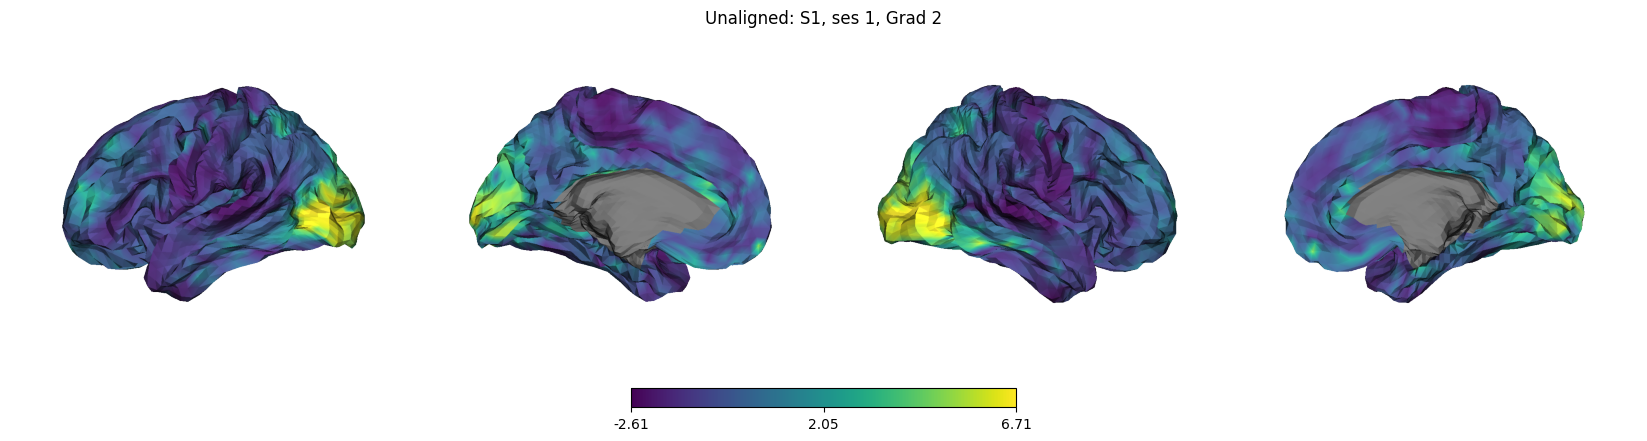

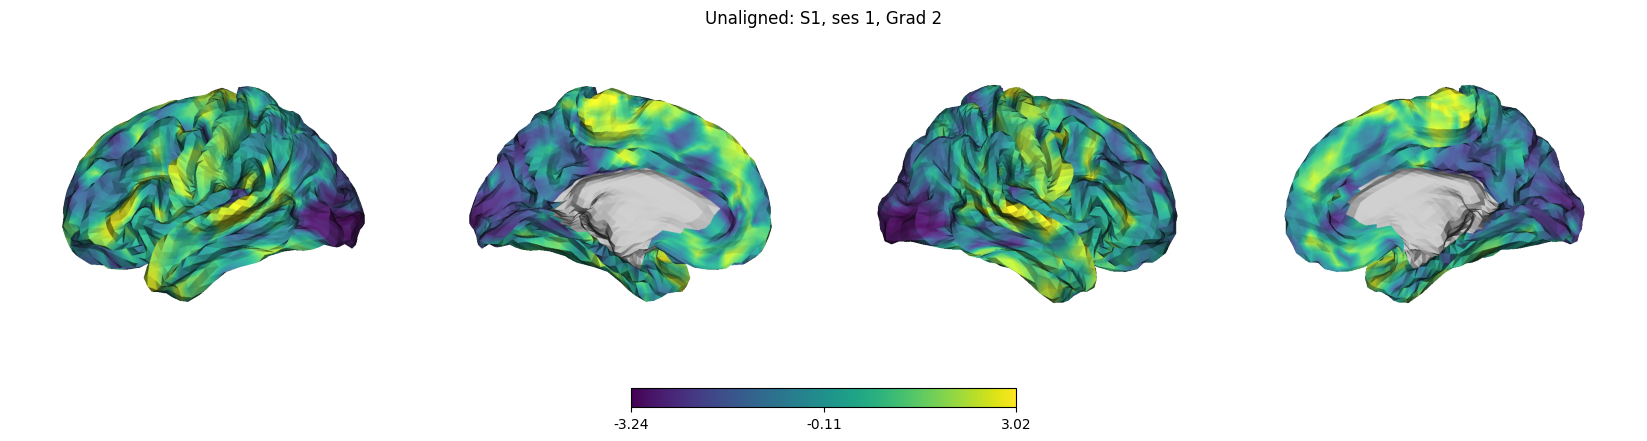

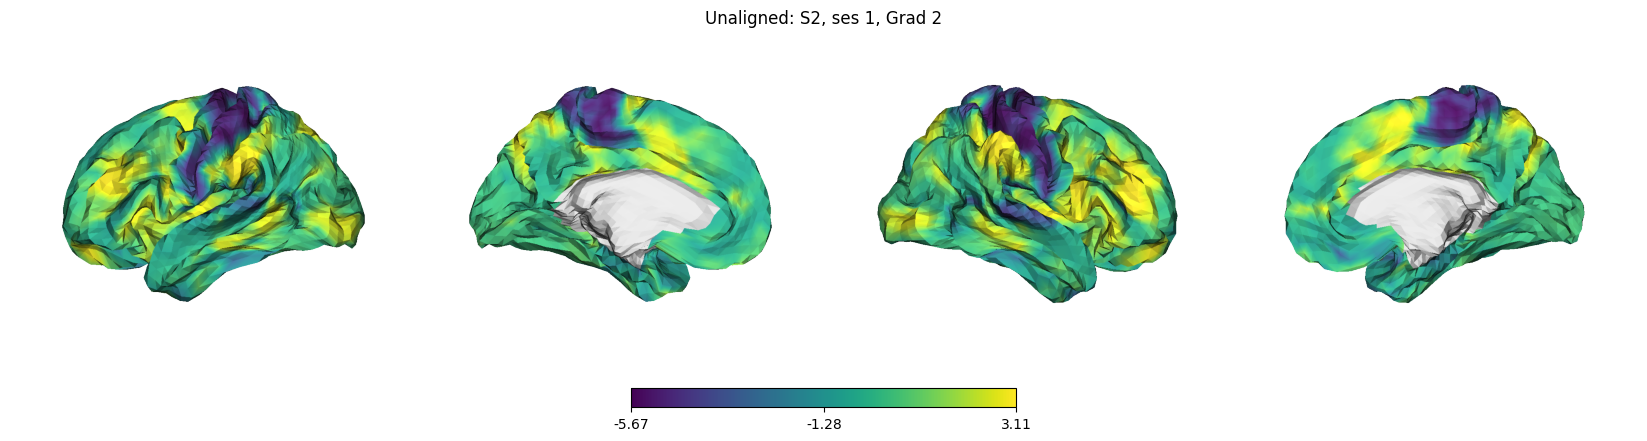

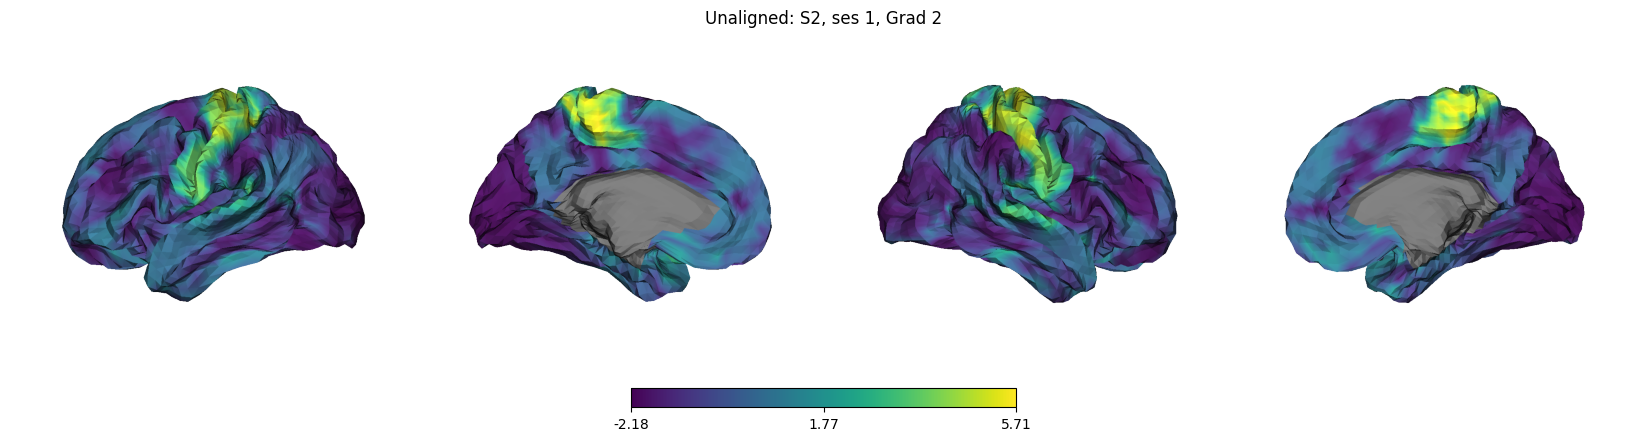

In [200]:
from surfplot.plotting import Plot

grad2_s1_ses1 = Plot("HCP/surfaces/fslr_L_mid_4k.gii", "HCP/surfaces/fslr_R_mid_4k.gii", layout='row', zoom=1.2, size=(2000,400), mirror_views=False)
grad2_s1_ses2 = Plot("HCP/surfaces/fslr_L_mid_4k.gii", "HCP/surfaces/fslr_R_mid_4k.gii", layout='row', zoom=1.2, size=(2000,400), mirror_views=False)
grad2_s2_ses1 = Plot("HCP/surfaces/fslr_L_mid_4k.gii", "HCP/surfaces/fslr_R_mid_4k.gii", layout='row', zoom=1.2, size=(2000,400), mirror_views=False)
grad2_s2_ses2 = Plot("HCP/surfaces/fslr_L_mid_4k.gii", "HCP/surfaces/fslr_R_mid_4k.gii", layout='row', zoom=1.2, size=(2000,400), mirror_views=False)

grad2_s1_ses1.add_layer(gradients4k_labeled_ses1[0][1], cmap='viridis')
grad2_s1_ses2.add_layer(gradients4k_labeled_ses2[0][1], cmap='viridis')

grad2_s2_ses1.add_layer(gradients4k_labeled_ses1[1][1], cmap='viridis')
grad2_s2_ses2.add_layer(gradients4k_labeled_ses2[1][1], cmap='viridis')



grad2_s1_ses1 = grad2_s1_ses1.build()
grad2_s1_ses1.axes[0].set_title("Unaligned: S1, ses 1, Grad 2")

grad2_s1_ses2 = grad2_s1_ses2.build()
grad2_s1_ses2.axes[0].set_title("Unaligned: S1, ses 1, Grad 2")

grad2_s2_ses1 = grad2_s2_ses1.build()
grad2_s2_ses1.axes[0].set_title("Unaligned: S2, ses 1, Grad 2")

grad2_s2_ses2 = grad2_s2_ses2.build()
grad2_s2_ses2.axes[0].set_title("Unaligned: S2, ses 1, Grad 2")

grad2_s1_ses1.show()
grad2_s1_ses2.show()
grad2_s2_ses1.show()
grad2_s2_ses2.show()

In [107]:
sessions_4k = sessions_4k.reshape(10, 3, 8004)
#gradients4k_all_sessions = [subject_grads[:, ~(subject_grads == 0).all(axis=0)] for subject_grads in sessions_4k]


In [110]:
sessions_4k[0][0].shape

(8004,)

In [296]:
from brainspace.gradient.alignment import ProcrustesAlignment

alignment = ProcrustesAlignment()
gradients4k_all_sessions_aligned = alignment.fit(gradients4k_all_sessions[1:], gradients4k_all_sessions[0])

In [297]:
np.save(file = "aligned_gradients.npy", arr = np.asarray(gradients4k_all_sessions_aligned.aligned_))

In [166]:
all_gradients4k_all_sessions_aligned[0][0].shape
cortical_indices_4k_metric.shape

(7344,)

(8004,)

In [162]:
all_gradients4k_all_sessions_aligned = np.load("aligned_gradients.npy")
all_gradients4k_all_sessions_aligned = np.insert(arr = all_gradients4k_all_sessions_aligned, obj = 0, values = np.expand_dims(gradients4k_all_sessions[0], axis = 0), axis = 0)

In [182]:
labs_L_4k_metric = nib.load('HCP/labels/fsLR.4k.L.label_metric.gii').agg_data()
labs_R_4k_metric = nib.load('HCP/labels/fsLR.4k.R.label_metric.gii').agg_data()
labs_4k_metric  = np.concatenate((labs_L_4k_metric, labs_R_4k_metric))

In [154]:
labs_L_4k = nib.load('HCP/labels/fsLR.4k.L.label.gii').agg_data()
labs_R_4k = nib.load('HCP/labels/fsLR.4k.R.label.gii').agg_data()
labs_4k  = np.concatenate((labs_L_4k, labs_R_4k))

In [190]:
labs_4k_metric = labs_4k_metric.astype(float)
labs_4k_metric[labs_4k_metric == 0] = np.nan
cortical_indices_4k_metric = np.where(np.isnan(labs_4k_metric) == False)[0]

labs_4k = labs_4k.astype(float)
labs_4k[labs_4k == 0] = np.nan
medial_wall_mask = np.where(np.isnan(labs_4k) == True)[0]

In [191]:
medial_wall_mask.shape

(685,)

In [189]:
labs_4k_metric[np.isnan(labs_4k_metric) == False].shape

(7344,)

In [181]:
labs_4k_metric[np.isnan(labs_4k_metric) != True].shape

(7319,)

In [193]:
grads_ses1_4k_aligned = all_gradients4k_all_sessions_aligned[:int(len(all_gradients4k_all_sessions_aligned)/2)] # shape (subj, grad, vertices)
grads_ses2_4k_aligned = all_gradients4k_all_sessions_aligned[int(len(all_gradients4k_all_sessions_aligned)/2):]

labeled_grads_ses1_4k_aligned = np.empty((5, 3, 8004))
labeled_grads_ses1_4k_aligned[:] = np.nan

labeled_grads_ses2_4k_aligned = np.empty((5, 3, 8004))
labeled_grads_ses2_4k_aligned[:] = np.nan

for subject, subject_map in zip(grads_ses1_4k_aligned, labeled_grads_ses1_4k_aligned):
    subject_map[0][cortical_indices_4k_metric] = subject[0]
    subject_map[0][medial_wall_mask] = np.nan
    subject_map[1][cortical_indices_4k_metric] = subject[1]
    subject_map[1][medial_wall_mask] = np.nan
    subject_map[2][cortical_indices_4k_metric] = subject[2]
    subject_map[2][medial_wall_mask] = np.nan

for subject, subject_map in zip(grads_ses2_4k_aligned, labeled_grads_ses2_4k_aligned):
    subject_map[0][cortical_indices_4k_metric] = subject[0]
    subject_map[0][medial_wall_mask] = np.nan
    subject_map[1][cortical_indices_4k_metric] = subject[1]
    subject_map[1][medial_wall_mask] = np.nan
    subject_map[2][cortical_indices_4k_metric] = subject[2]
    subject_map[2][medial_wall_mask] = np.nan

ValueError: shape mismatch: value array of shape (7344,) could not be broadcast to indexing result of shape (7319,)

In [197]:
labeled_grads_ses1_4k_aligned[0][1]

array([-0.48637721, -1.36099386, -0.46750632, ...,  0.04516719,
       -0.21844105,  0.10850967])

Text(0.5, 1.0, 'Procrustes aligned: S1, ses 1, Grad 2')

Text(0.5, 1.0, 'Procrustes aligned: S1, ses 1, Grad 2')

Text(0.5, 1.0, 'Procrustes aligned: S2, ses 1, Grad 2')

Text(0.5, 1.0, 'Procrustes aligned: S2, ses 1, Grad 2')

/var/folders/2m/72fcyjmd7vs3g18rkfwx7nw40000gn/T/ipykernel_87952/2890690409.py:25: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  grad2_s1_ses1.show()
/var/folders/2m/72fcyjmd7vs3g18rkfwx7nw40000gn/T/ipykernel_87952/2890690409.py:26: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  grad2_s1_ses2.show()
/var/folders/2m/72fcyjmd7vs3g18rkfwx7nw40000gn/T/ipykernel_87952/2890690409.py:27: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  grad2_s2_ses1.show()
/var/folders/2m/72fcyjmd7vs3g18rkfwx7nw40000gn/T/ipykernel_87952/2890690409.py:28: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  grad2_s2_ses2.show()


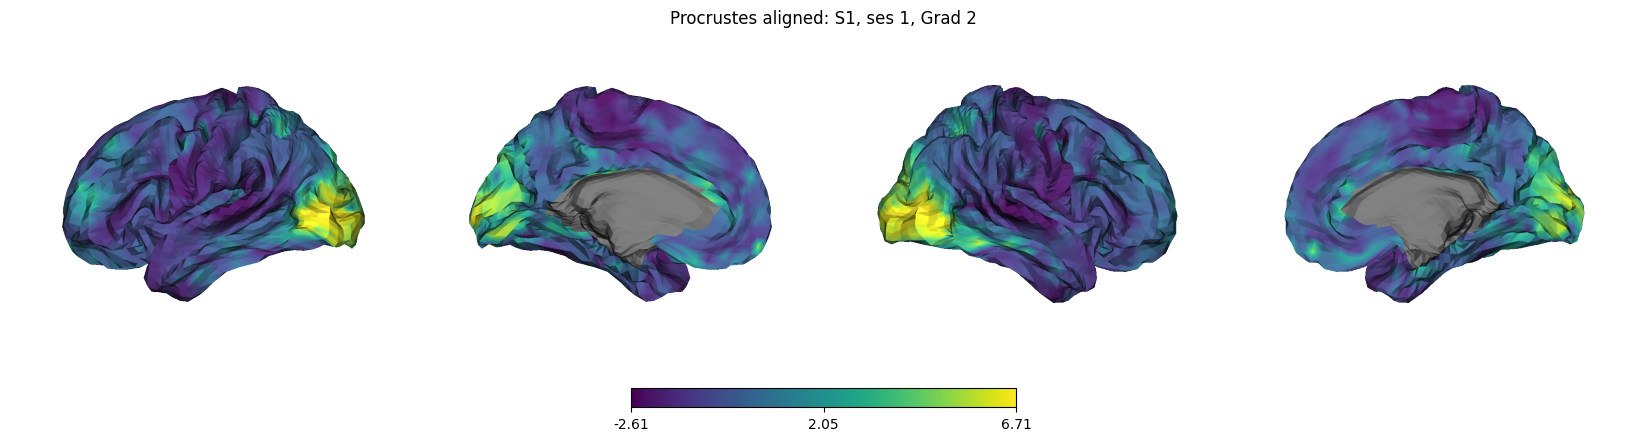

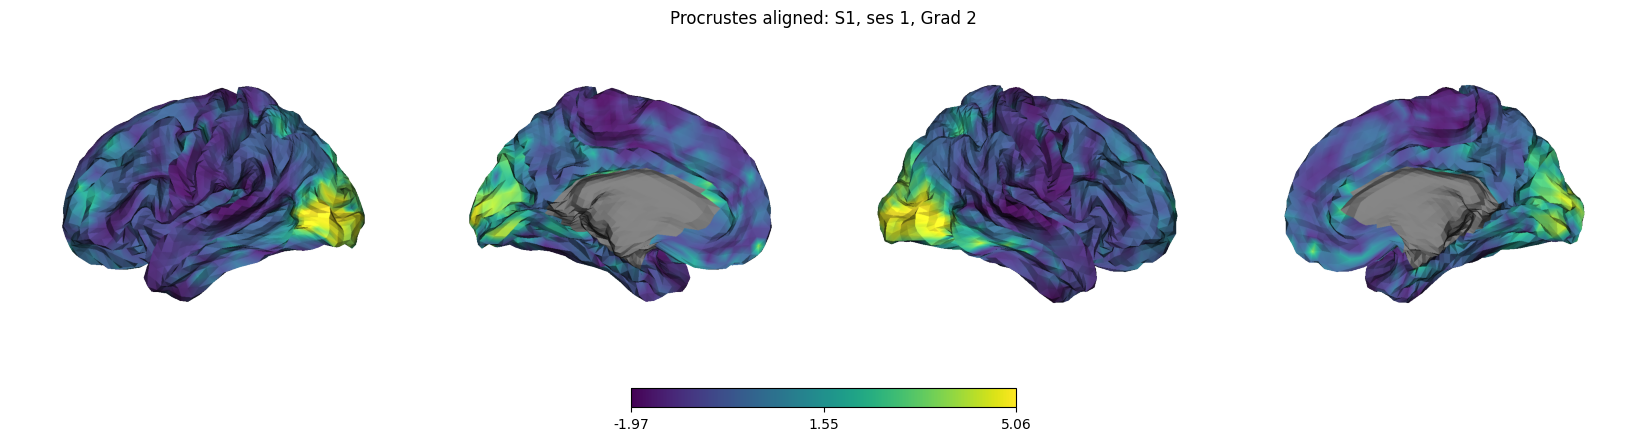

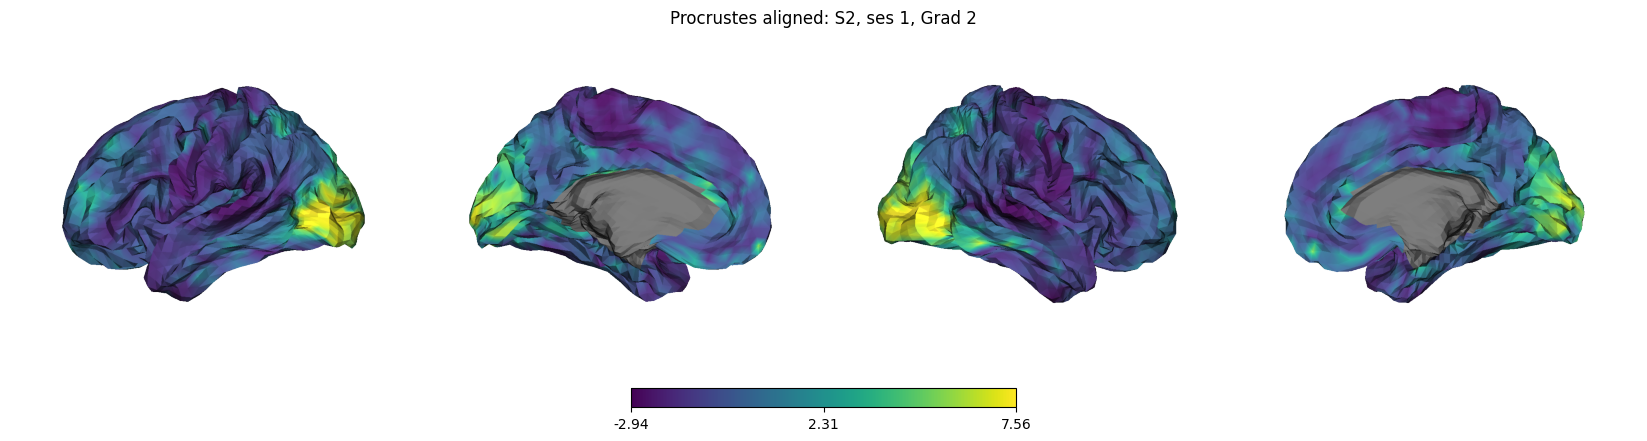

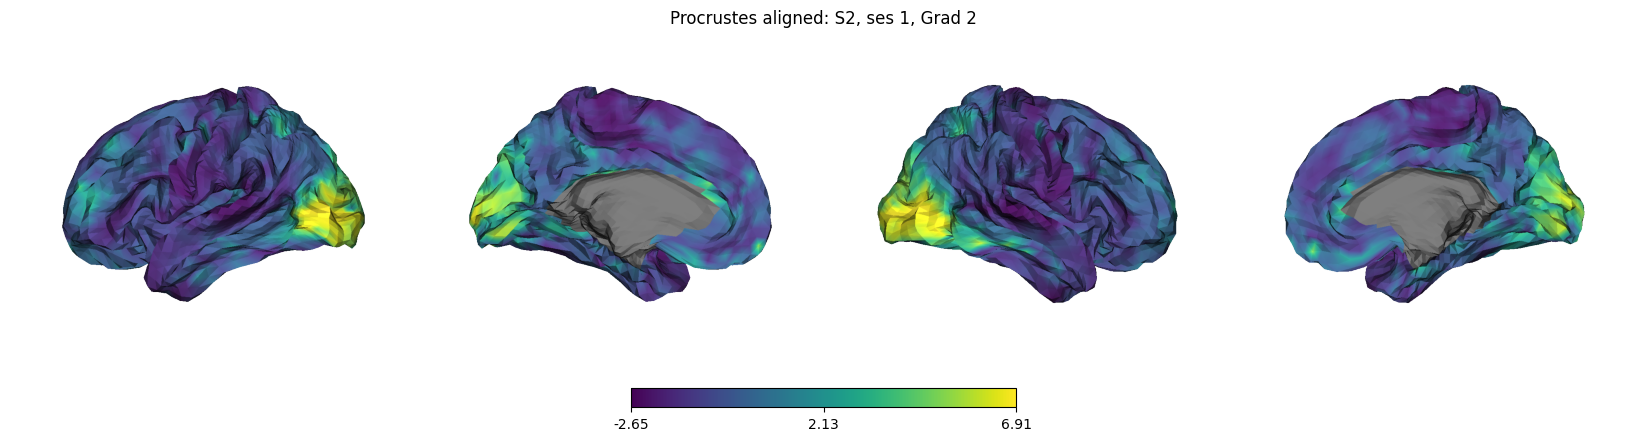

In [201]:
grad2_s1_ses1 = Plot("HCP/surfaces/fslr_L_mid_4k.gii", "HCP/surfaces/fslr_R_mid_4k.gii", layout='row', zoom=1.2, size=(2000,400), mirror_views=False)
grad2_s1_ses2 = Plot("HCP/surfaces/fslr_L_mid_4k.gii", "HCP/surfaces/fslr_R_mid_4k.gii", layout='row', zoom=1.2, size=(2000,400), mirror_views=False)
grad2_s2_ses1 = Plot("HCP/surfaces/fslr_L_mid_4k.gii", "HCP/surfaces/fslr_R_mid_4k.gii", layout='row', zoom=1.2, size=(2000,400), mirror_views=False)
grad2_s2_ses2 = Plot("HCP/surfaces/fslr_L_mid_4k.gii", "HCP/surfaces/fslr_R_mid_4k.gii", layout='row', zoom=1.2, size=(2000,400), mirror_views=False)

grad2_s1_ses1.add_layer(labeled_grads_ses1_4k_aligned[0][1], cmap='viridis')
grad2_s1_ses2.add_layer(labeled_grads_ses2_4k_aligned[0][1], cmap='viridis')

grad2_s2_ses1.add_layer(labeled_grads_ses1_4k_aligned[1][1], cmap='viridis')
grad2_s2_ses2.add_layer(labeled_grads_ses2_4k_aligned[1][1], cmap='viridis')


grad2_s1_ses1 = grad2_s1_ses1.build()
grad2_s1_ses1.axes[0].set_title("Procrustes aligned: S1, ses 1, Grad 2")

grad2_s1_ses2 = grad2_s1_ses2.build()
grad2_s1_ses2.axes[0].set_title("Procrustes aligned: S1, ses 1, Grad 2")

grad2_s2_ses1 = grad2_s2_ses1.build()
grad2_s2_ses1.axes[0].set_title("Procrustes aligned: S2, ses 1, Grad 2")

grad2_s2_ses2 = grad2_s2_ses2.build()
grad2_s2_ses2.axes[0].set_title("Procrustes aligned: S2, ses 1, Grad 2")

grad2_s1_ses1.show()
grad2_s1_ses2.show()
grad2_s2_ses1.show()
grad2_s2_ses2.show()

In [263]:
from sklearn.neighbors import NearestNeighbors

vd_subject_list_4k_ses1 = []
for subject_grads in gradients4k_labeled_ses1:
    gradient4k = subject_grads[:, ~np.isnan(subject_grads).all(axis=0)]
    vertex_coords = gradient4k.T
    vertex_nbrs = NearestNeighbors(n_neighbors=6, algorithm='auto').fit(vertex_coords)
    distances, indices = vertex_nbrs.kneighbors(vertex_coords)
    mean_distances = distances.mean(axis = 1)
    vd_subject_list_4k_ses1.append(mean_distances)


vd_subject_list_4k_ses2 = []
for subject_grads in gradients4k_labeled_ses2:
    gradient4k = subject_grads[:, ~np.isnan(subject_grads).all(axis=0)]
    vertex_coords = gradient4k.T
    vertex_nbrs = NearestNeighbors(n_neighbors=6, algorithm='auto').fit(vertex_coords)
    distances, indices = vertex_nbrs.kneighbors(vertex_coords)
    mean_distances = distances.mean(axis = 1)
    vd_subject_list_4k_ses2.append(mean_distances)

In [261]:

gradients_labeled_ses1[0][:, ~np.isnan(gradients_labeled_ses1[0]).all(axis=0)].shape

(3, 7293)

In [256]:
gradients_labeled_ses1[0][0][~np.isnan(gradients_labeled_ses1[0][0])].shape

(7293,)

In [ ]:
gradients_labeled_ses1[0]

In [247]:
gradients_labeled_ses1[0].shape

(21879,)

In [245]:
gradients_ses2[0].T.shape

(59412, 3)

In [ ]:
vd_4k_ses1 = np.asarray(vd_subject_list_ses1)
vd_4k_ses2 = np.asarray(vd_subject_list_ses2)